# Lane Lines Detection

## I. Lane Lines Detection on Image 

In [1]:
# Setup import the required library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.interpolate as interpolate
import cv2
from PIL import Image

# Pipeline function to process image
# Inputs:
#     image: image file
#     output_file: path to the output image
#     show_image: to show step-by-step images as they are processed
#     show_hough: show the points from Hough transform on image
#     isVideo: true to return original image if no lines detected in Hough as this breaks the loop otherwise

def pipeline(image, output_file=False, show_image=False, show_hough=False, isVideo=False):
    # Copies of the image
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    copy_image = np.copy(image) # create another copy for the line drawing at the end
    hough_image = np.copy(image) # copy to show the result of hough detection on image for debugging
    
    # Grayscale image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian smoothing to reduce noise
    blur_gray = cv2.GaussianBlur(gray,(5, 5),0)
    if show_image:
        plt.imshow(blur_gray, cmap='gray')
        plt.show()
    
    # Cannyfy to extract edges
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    if show_image:
        plt.imshow(edges)
        plt.show()

    # Create a polygon mask to select region of interest
    # Here I divided them into two sections for easier averaging post-Hough
    ignore_mask_color = 255   
    imshape = image.shape
    
    mask_left = np.zeros_like(edges)   
    vertices_left = np.array([[(0,imshape[0]),(450, imshape[0]*0.6), (475, imshape[0]*0.6), (475,imshape[0])]], dtype=np.int32)
    mask_right = np.zeros_like(edges)   
    vertices_right = np.array([[(475,imshape[0]),(475, imshape[0]*0.6), (500, imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
    
    cv2.fillPoly(mask_left, vertices_left, ignore_mask_color)
    masked_edges_left = cv2.bitwise_and(edges, mask_left)
    
    cv2.fillPoly(mask_right, vertices_right, ignore_mask_color)
    masked_edges_right = cv2.bitwise_and(edges, mask_right)
    
    lines_left, lines_right = Hough_transform(masked_edges_left, masked_edges_right)
    
    if isVideo:
        if lines_left is None or lines_right is None:
            return copy_image
    
    lines_left_extended, lines_right_extended = extrapolate(imshape, lines_left, lines_right)
    lines = np.append([lines_left_extended], [lines_right_extended], axis=0)
    
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            
    if show_hough:
        lines_hough = np.append(lines_left, lines_right, axis=0)
        for line in lines_hough:
            for x1,y1,x2,y2 in line:
                cv2.line(hough_image,(x1,y1),(x2,y2),(255,0,0),10)
        plt.imshow(hough_image)
        plt.show()
        
     # Apply lines as overlay on the image
    copy_edges = cv2.addWeighted(line_image, 0.8, copy_image, 1, 0) 
    
    if show_image:
        plt.imshow(copy_edges)
        plt.show()

    # To save the images(s)
    if output_file:
        im = Image.fromarray(copy_edges)
        im.save(output_file)
    
    return copy_edges

# No good as a function, but as a section of a whole is convenient. Change params here to experiment.
def Hough_transform(masked_edges_left, masked_edges_right):
    # Define the Hough transform parameters
    # Hough parameters setup
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = 2*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 # minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected
    # Output "lines" is an array containing endpoints of detected line segments
    lines_left = cv2.HoughLinesP(masked_edges_left, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    lines_right = cv2.HoughLinesP(masked_edges_right, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    return [lines_left, lines_right]

def predict_y(coord_x, lines):
    x, y = [], []
    for line in lines:
        for x1, y1, x2, y2 in line:
            x.append(x1)
            y.append(y1)
            x.append(x2)
            y.append(y2)
            
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        return int(p(coord_x))
        
def extrapolate(imshape, lines_left, lines_right):
    lines_left_extended = [np.array([0, predict_y(0, lines_left), int(imshape[1]/2), predict_y(imshape[1]/2, lines_left)])]
    lines_right_extended = [np.array([int(imshape[1]/2), predict_y(imshape[1]/2, lines_right), imshape[1], predict_y(imshape[1], lines_right)])]
    
    return lines_left_extended, lines_right_extended

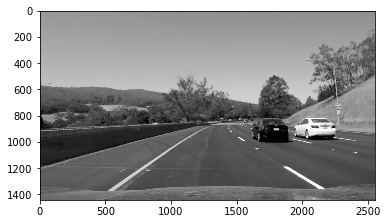

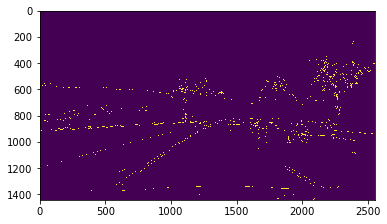

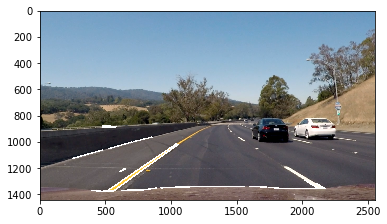

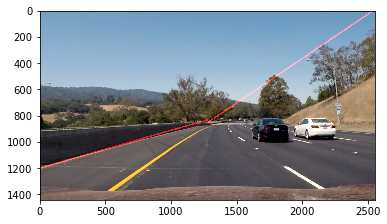

In [2]:
# challenge screenshot
plt.imshow(pipeline(mpimg.imread('./test_images/challenge.jpg'), './result_images/challenge.png', True, True))
# plt.show()

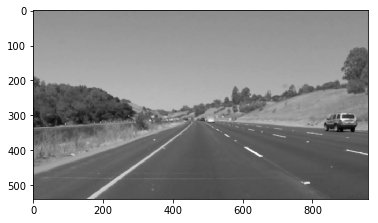

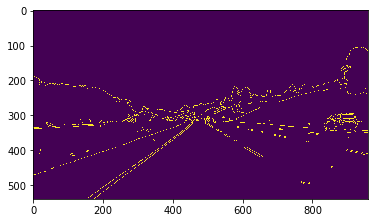

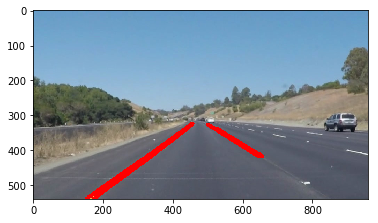

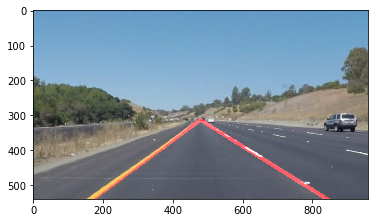

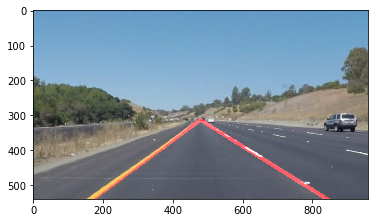

In [3]:
# First image test
plt.imshow(pipeline(mpimg.imread('./test_images/solidYellowCurve.jpg'), './result_images/solidYellowCurve.png'))
plt.show()

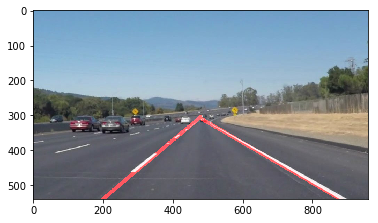

In [8]:
plt.imshow(pipeline(mpimg.imread('./test_images/solidWhiteCurve.jpg'), './result_images/solidWhiteCurve.png'))
plt.show()

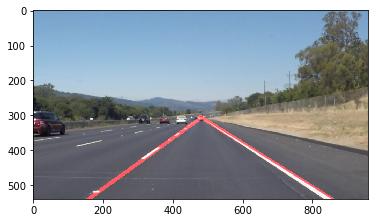

In [9]:
plt.imshow(pipeline(mpimg.imread('./test_images/solidWhiteRight.jpg'), './result_images/solidWhiteRight.png'))
plt.show()

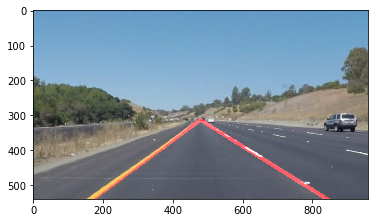

In [10]:
plt.imshow(pipeline(mpimg.imread('./test_images/solidYellowCurve.jpg'), './result_images/solidYellowCurve.png'))
plt.show()

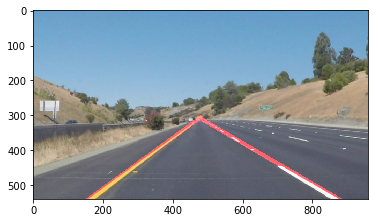

In [11]:
plt.imshow(pipeline(mpimg.imread('./test_images/solidYellowCurve2.jpg'), './result_images/solidYellowCurve2.png'))
plt.show()

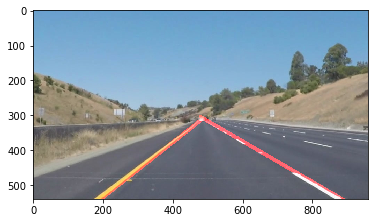

In [12]:
plt.imshow(pipeline(mpimg.imread('./test_images/whiteCarLaneSwitch.jpg'), './result_images/whiteCarLaneSwitch.png'))
plt.show()

## II. Lane Lines Detection in Video

In [14]:
# Importing modules for video conversion. 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
# Create new video files. Can do loop but - later.
new_clip_output = './result_videos/solidWhiteRight.mp4'
test_clip = VideoFileClip("./test_videos/solidWhiteRight.mp4")
new_clip = test_clip.fl_image(lambda x: pipeline(x, False, False, False, True)) #NOTE: this function expects color images!!
%time new_clip.write_videofile(new_clip_output, audio=False)

# new_clip_output1 = './result_videos/solidYellowLeft.mp4'
# test_clip1 = VideoFileClip("./test_videos/solidYellowLeft.mp4")
# new_clip1 = test_clip1.fl_image(lambda x: pipeline(x, False, False, False, True)) #NOTE: this function expects color images!!
# %time new_clip1.write_videofile(new_clip_output1, audio=False)

# new_clip_output2 = './result_videos/challenge.mp4'
# test_clip2 = VideoFileClip("./test_videos/challenge.mp4")
# new_clip2 = test_clip2.fl_image(lambda x: pipeline(x, False, False, False, True)) #NOTE: this function expects color images!!
# %time new_clip2.write_videofile(new_clip_output2, audio=False)

[MoviePy] >>>> Building video ./result_videos/solidWhiteRight.mp4
[MoviePy] Writing video ./result_videos/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result_videos/solidWhiteRight.mp4 

CPU times: user 3.22 s, sys: 380 ms, total: 3.6 s
Wall time: 9.01 s


In [1]:
# # Render
# HTML("""
# <video width="640" height="300" controls>
#   <source src="{0}" type="video/mp4">
# </video>
# """.format(new_clip_output))